# 16S rRNA Data Curation, Processing, Augmentation and Exploratory Analysis
This juptyer notebook goes through every step on how the 16S rRNA data used for training and testing the machine/deep learning models was obtained, curated, processed and visualised.

## Data Curation, Processing and Augmentation

The original full-length 16S rRNA sequences were obtained from the EzBio (61,827), GRD (12,939) and UDB (12,988) 16S databases. These were combined into 1 single dataset (87,754) which, after initial curation, resulted in a dataset of **70,785** entries.

This initial curation process consisted of:
- loading the csv files as a pandas data frame
- concatenating three data frames
- removing sequences that contain more than 1% ambiguous bases
- removing sequences that contain no taxonomic information at family, genus and species level
- unspecific taxon labels were replaced with NaN values

As this initial process was partially completed manually with excel (due to the inconsistent and evolving nature of the taxonomic nomenclature of prokaryotes), the step-by-step scripts in this jupyter notebook initialise with the combined dataset (full_curated_dataset.csv).

In order to distinguish incorrect or old taxon labels from correct ones, the List of Prokaryotic names with Standing in Nomenclature (LPSN) was used which can be accessed via this link: https://lpsn.dsmz.de/

The next few code cells contain some of the scripts that were used during the initial curation process, but they are not completely executable in this context.

In [1]:
from Bio import SeqIO
import numpy as np, pandas as pd

In [66]:
seq_file = SeqIO.parse('16S-UDb_sequences.fasta','fasta')
taxon_info = open('16S-UDb_MOTHUR_taxonomy.txt','r')
lines = taxon_info.readlines()

# generate a matrix containing several lists that contain taxonomy information for each sequence id entry
# example: [[id1, kingdom, phylum, ..., species], [id2, kingdom, phylum, ..., species], ...]
taxList = []
for line in lines:
    line = line.strip()
    id, semi_tax = line.split('\t')[0], line.split('\t')[1]
    taxs = semi_tax.split(';')
    taxs.insert(0, id)
    taxList.append(taxs)

# initiate seq_dict containing seq_id as a key and seq as a value
seq_dict = SeqIO.to_dict(SeqIO.parse(seq_file, "fasta"))

# add sequence to the matrix using the seq_id dictionary
for tax in taxList:
    tax.append(seq_dict[tax[0]])

# delete rows with too many columns
result = [entry for entry in taxList if len(entry) == 9]

# create Pandas dataframe 
taxon_column = [
    'Seq_id', 'Kingdom','Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence'
    ]
taxon_df = pd.DataFrame(data = result, columns = taxon_column)
taxon_df.head(5)

,ID,Kingdom,Phylum,Class,Order,Family,Genus,Species,seq
0,4321924,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Corynebacteriaceae,Corynebacterium,durum,GAGTTTGATCATGGCTCAGGACGAACGCTGGCGGCGTGCTTAACAC...
1,1042479,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,melaninogenica,GATGAACGCTAGCTATAGGCTTAACACATGCAAGTCGAGGGGAAAC...
2,557633,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Microbacteriaceae,Microbacterium,chocolatum,GATGAACGCTGGCGGCGTGCTTACACATGCAGTCTACCGGTGAAGC...
3,345899,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,copri,AGAGTTTGATTCTGGCTCAGGATGAACGCTAGCTACAGGCTTAACA...
4,299514,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium,perfringens,AGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAACA...


In [ ]:
# Script to combine (seprately curated) data frames
frames = [UDB, EZBIO, GRD]
tot_df = pd.concat(frames).reset_index()

# --------------------------------------------------------------------------------------------

# Returns True if a sequence contains more than a certain percantage of 'N' (ambiguous bases)
def too_much_N(sequence, percentage = 0.01):
    sequence.count('N') / len(sequence) > percentage

# --------------------------------------------------------------------------------------------

# Returns the last word of string
def lastWord(string):
    # split by space and converting to list
    lis = list(string.split(" "))   
    # returning last element in list
    return lis[-1]                  

# --------------------------------------------------------------------------------------------

# Script to identify cells containing abnormal characters
bad_df = df[df.str.contains(r'[0-9!@#$%^&*()_+-=<>]')]

# --------------------------------------------------------------------------------------------

# Script to capitalize every taxon label from Kingdom to Genus
taxons = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence']
for taxon in taxons[:-2]:
    df[taxon] = df[taxon].str.capitalize()

# --------------------------------------------------------------------------------------------

# Script to remove chloroplast RNA
bad_df = df[df['Phylum'].str.contains('Chloroplast')]
df = df.drop(bad_df.index)

### 1. Deconverging the taxonomy
In order to train the RDP classifier without errors and retrieve meaningful results from the deep learning models, convergent evolution must be removed. The issue of converging evolution is demonstrated here:
- Bacteria / Verrucomicrobia / Verrucomicrobiae / Verrucomicrobiales / Verrucomicrobiaceae / Verrucomicrobium / Verrucomicrobium spinosum
- Bacteria / Verrucomicrobia / Verrucomicrobiae / Verrucomicrobiales / NaN                 / Verrucomicrobium / Verrucomicrobium alcali

The genus value (Verrucomicrobium) is equal for these two entries but the family label is missing for the second entry. The rules of taxonomic labelling do not allow this; **when a taxon for two organisms is equal, then all previous taxa in the taxonomic hierarchy must also be equal**.

But labelling every taxon is not always possible. When a sequence has not been identified at every taxonomic level or when a novel genus is identified, it may take a while before it is assigned to a specific family/class/order/... and this results in entires as shown below:
- Bacteria / Verrucomicrobia / Verrucomicrobiae / NaN / NaN / Verrucomicrobium / NaN
- Bacteria / Verrucomicrobia / Verrucomicrobiae / NaN / NaN / Verrucomicrobium / spinosum

In order to remove NaN values from the dataset in a meaningful way, one can make use of the previous taxon labels. And the full species name can be generated by adding the Genus_name to the species name.
- Bacteria / Verrucomicrobia / Verrucomicrobiae / c_Verrucomicrobiae / c_f_Verrucomicrobiae / Verrucomicrobium / Verrucomicrobium sp
- Bacteria / Verrucomicrobia / Verrucomicrobiae / c_Verrucomicrobiae / c_f_Verrucomicrobiae / Verrucomicrobium / Verrucomicrobium spinosum

In [2]:
df = pd.read_csv('full_curated_dataset.csv')
df.sample(10)

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Sequence
20808,Bacteria,Firmicutes,Bacilli,Caryophanales,Bacillaceae,Bacillus,depressus,ATACATGCAAGTCGAGCGAACTTGCGGGAGCTTGCTCCCAAAAGTT...
56449,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Rhodobaculum,claviforme,AACGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAGCGCACTC...
22441,Bacteria,Firmicutes,Bacilli,Caryophanales,Bacillaceae,Bascillus,thuringiensis,TTATTGGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTG...
48753,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Oxalobacteraceae,Oxalicibacterium,faecigallinarum,ATTGAACGCTGGCGGCATGCCTTACACATGCAAGTCGAACGGCAGC...
3142,Bacteria,Balneolaeota,Balneolia,Balneolales,Balneolaceae,NaN,NaN,GACGAACGCTGGCGGCGGGCCTAACACATGCAAGTCGTGGGAGAAG...
14357,Bacteria,Verrucomicrobia,Opitutae,Puniceicoccales,Puniceicoccaceae,NaN,NaN,AGTGAACGCTGGCGGCATGGTTAAGACATGCAAGTCGAACGAAAAG...
16084,Bacteria,Actinobacteria,Actinobacteria,Streptosporangiales,Thermomonosporaceae,Actinomadura,rayongensis,CGCTGGCGGCGTGCTTAACACATGCAAGTCGAGCGGAAAGGCCCTT...
15665,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,haemolyticus,AGGAATTGGCGGCAGCTTAAACATGCAAGTCGAGCGGAGTGGTTGT...
21355,Bacteria,Firmicutes,Bacilli,Caryophanales,Bacillaceae,Bacillus,purgationiresistens,AGCGAATTTATGGGAGCTTGCTCCCGTAAGTTAGCGGCGGACGGGT...
17467,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Aliivibrio,fischeri,TAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGG...


In [3]:
def empty_fill(df):
    taxons = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    taxon_acronym = ['k_', 'p_', 'c_', 'o_', 'f_', 'g_', ' sp']

    # enumerate over each column in the dataframe 
    # to automatically label the empty entries according to the aformentioned labelling
    for index, taxon in enumerate(taxons):
        # only at the species level, acryonym is added at the end
        if taxon == taxons[-1]:
            df[taxon][df[taxon].isna()] = df[taxons[index-1]] + taxon_acronym[index]
            
        else:
            df[taxon][df[taxon].isna()] = taxon_acronym[index] + df[taxons[index-1]]
            
    return df

In [4]:
df_empty_filled = empty_fill(df)
df_empty_filled.sample(10)

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Sequence
50670,Bacteria,Bacteroidetes,Sphingobacteriia,Sphingobacteriales,Sphingobacteriaceae,Pedobacter,alluvionis,GATGAACGCTAGCGGCAGGCCTAATACATGCAAGTCGAACGATAGA...
44060,Bacteria,Proteobacteria,Alphaproteobacteria,Hyphomicrobiales,Phyllobacteriaceae,Mesorhizobium,ciceri,AACTCTACCTGGCGATACTCTTAGTGTATGCAAGTCACCGTGCCCG...
56520,Bacteria,Actinobacteria,Actinobacteria,Mycobacteriales,Nocardiaceae,Rhodococcus,fascians,GGCTCAGGACGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAG...
66207,Bacteria,Firmicutes,Clostridia,Eubacteriales,Syntrophomonadaceae,Syntrophomonas,cellicola,AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...
23907,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Brevundimonas,terrae,ACGGACCCTTCGGGGTTAGTGGCGGACGGGTGAGTAACACGTGGGA...
25755,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Celeribacter,marinus,AACGAACGCTGGCGGCACGCCTAACACATGCAAGTCGAGCGCTACC...
55272,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Pseudooceanicola,batsensis,AACGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAGCGAAGCC...
16445,Bacteria,Actinobacteria,Actinobacteria,Pseudonocardiales,Pseudonocardiaceae,Actinosynnema,mirum,TTATTGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...
4984,Bacteria,Firmicutes,Clostridia,Eubacteriales,Christensenellaceae,g_Christensenellaceae,g_Christensenellaceae sp,GACAAACGCTGGCGGCGTGCCTAACACATGCAAGTCGAGCGGAGAT...
49096,Bacteria,Firmicutes,Bacilli,Caryophanales,Paenibacillaceae,Paenibacillus,chibensis,TTGTATGAGGAGCTTGCTCCTCTGAAGGTTAGCGGCGGACGGGTGA...


In [5]:
def standardize_sp(df):
    not_sub_df = df[df['Species'].str.contains(' ')]
    sub_df = df[ ~ df['Species'].str.contains(' ')]

    sub_df_copy = sub_df.copy()
    sub_df_copy['Species'] = sub_df['Genus'] + ' ' + sub_df['Species']

    return pd.concat([not_sub_df, sub_df_copy])

In [6]:
df_filled = standardize_sp(df_empty_filled)
df_filled.sample(10)

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Sequence
17236,Bacteria,Bacteroidetes,Cytophagia,Cytophagales,Flammeovirgaceae,Algivirga,Algivirga pacifica,GATGAACGCTAGCGGCAGGCCTAATACATGCAAGTCGAGGGGTAAC...
66213,Bacteria,Firmicutes,Clostridia,Eubacteriales,Syntrophomonadaceae,Syntrophomonas,Syntrophomonas palmitatica,GACGAACGCTGGCGGCGTGCCTAACACATGCAAGTCGAACGGGTGC...
28283,Bacteria,Actinobacteria,Actinobacteria,Mycobacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium bovis,AAUGAGUUGAUCCUGGCUCAGGACGAACGCUGGCGGCGUGCUUAAC...
11447,Bacteria,Proteobacteria,Deltaproteobacteria,Bradymonadales,Bradymonadaceae,g_Bradymonadaceae,g_Bradymonadaceae sp,AACGAACGCTGGCGGCGTGCCTAACACATGCAAGTCGAGCGAGAAA...
22194,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides tectus,GATGAACGCTAGCTACAGGCTTAACACATGCAAGTCGAGGGGCAGC...
67525,Bacteria,Deinococcus-thermus,Deinococci,Thermales,Thermaceae,Thermus,Thermus islandicus,GGTGAACGCTGGCGGCGTGCCTAAGACATGCAAGTCGTGCGGGCCG...
69067,Bacteria,Firmicutes,Negativicutes,Veillonellales,Veillonellaceae,Veillonella,Veillonella dispar,GACGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGAAGAG...
21962,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides acidifaciens,AGAGTTTGATCCTGGCTCAGGATGAACGCTAGCTACAGGCTTAACA...
54406,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas arsenicoxydans,ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAGCGGTAGA...
34401,Bacteria,Armatimonadetes,Fimbriimonadia,Fimbriimonadales,Fimbriimonadaceae,Fimbriimonas,Fimbriimonas sp,GCCTAATACATGCAAGTCGAACGAGGGCTTCGGCCCTAGTGGCGAA...


### 2. Removing too short/long nucleotide sequences

Some entries still contain sequences that are too short of too long to be informative.

These sequences will be removed using a function for which minimum and maximum lengths can be specified.

In [8]:
seq_len_series0 = df_filled['Sequence'].apply(lambda seq: len(seq))
print(
    'Shortest sequence: {}\nLongest sequence: {}\nAverage sequence lenght: {}'.format(
        seq_len_series0.min(), seq_len_series0.max(), round(seq_len_series0.mean())
        )
    )

Shortest sequence: 65
Longest sequence: 2933
Average sequence lenght: 1451


In [9]:
def keep_min_max_len(df, min_max = (1000, 2000)):
    seq_len_series = df['Sequence'].apply(lambda seq: len(seq))
    min_bool = min_max[0] <= seq_len_series
    max_bool = seq_len_series <= min_max[1]
    new_df = df[min_bool & max_bool]

    return new_df

In [10]:
df_full = keep_min_max_len(df_filled)

seq_len_series1 = df_full['Sequence'].apply(lambda seq: len(seq))
print(
    'Shortest sequence: {}\nLongest sequence: {}\nAverage sequence lenght: {}'.format(
        seq_len_series1.min(), seq_len_series1.max(), round(seq_len_series1.mean())
        )
    )

Shortest sequence: 1000
Longest sequence: 1995
Average sequence lenght: 1452


In [11]:
print(
    'Amount of entries before ({}) and after ({}) setting a min/max sequence length'.format(
        len(df_filled), len(df_full)
        )
    )

Amount of entries before (70785) and after (70664) setting a min/max sequence length


### 3. Removing ambiguous bases

In order to investigate how including ambiguous bases to the dataset effects the classification accuracy, a subset containing no ambiguous bases was created. 
To get an idea on how many of the entries contain ambiguous bases, a few simple comparisons were set up.

In [12]:
def non_amb(df):
    return df[ ~ df['Sequence'].str.contains(r'[YRWSKMDVHBNX]')]

In [13]:
# dataframe without any ambiguous bases in the sequence column
df_non_ambiguous = non_amb(df_full)

print(
    'DF with ambiguous bases sequences: {}\n{}\n\nDF without ambiguous bases sequences: {}\n{}'.format(
        df_full.shape, df_full['Species'].value_counts(), 
        df_non_ambiguous.shape, df_non_ambiguous['Species'].value_counts()
        )
    )

DF with ambiguous bases sequences: (70664, 8)
g_Oscillospiraceae sp          1238
g_Lachnospiraceae sp           1165
Escherichia coli                909
g_Planctomycetaceae sp          704
g_Christensenellaceae sp        666
                               ... 
Modestobacter lapidis             1
Bifidobacterium saguini           1
Modestobacter multiseptatus       1
Modestobacter muralis             1
Legionella erythra                1
Name: Species, Length: 18186, dtype: int64

DF without ambiguous bases sequences: (65116, 8)
g_Oscillospiraceae sp         1141
g_Lachnospiraceae sp          1077
Escherichia coli               896
g_Planctomycetaceae sp         635
g_Christensenellaceae sp       614
                              ... 
Micromonospora fluostatini       1
Micromonospora fulva             1
Micromonospora haikouensis       1
Micromonospora halophytica       1
Legionella bozemanae             1
Name: Species, Length: 16658, dtype: int64


### 4. Setting up a minimum number of entries requirement

As the deep learning models split the data into a training/validation/test set, a minimum of 5 (and preferably 10) representatives for a specific label are required in order to ensure each stratum contains at least 1 or 2 sequences of each unique taxon.

In [14]:
# demanding a minimum of 10 representatives at the species level
def min_entries(df, taxon = 'Species', min = 10):
    return df[df[taxon].map(df[taxon].value_counts()) > min]

In [15]:
# with ambiguous bases
df_min = min_entries(df_full)
# without ambiguous bases
df_non_amb_min = min_entries(df_non_ambiguous)

In [16]:
# reduction in the amount of entries and unique species
print(
    'ENTRIES | UNIQUE SPECIES\n\n  {} | {}  - without data restrictions\n  {} | {}  - after no-ambiguity restriction\n  {} | {}    - after minimal-species restriction\n  {} | {}    - after no-ambiguity AND minimal species restriction\n\n {} | {} - % representation-loss with both restrictions\n                   (no ambiguous bases and minimal amount of entries at species level'.format(
        len(df_full), df_full['Species'].nunique(), 
        len(df_non_ambiguous), df_non_ambiguous['Species'].nunique(), 
        len(df_min), df_min['Species'].nunique(), 
        len(df_non_amb_min), df_non_amb_min['Species'].nunique(), 
        round((len(df_full) - len(df_non_amb_min)) / len(df_full), 4), 
        round((df_full['Species'].nunique() - df_non_amb_min['Species'].nunique()) / df_full['Species'].nunique(), 4)
        )
    )

ENTRIES | UNIQUE SPECIES

  70664 | 18186  - without data restrictions
  65116 | 16658  - after no-ambiguity restriction
  39067 | 824    - after minimal-species restriction
  36351 | 784    - after no-ambiguity AND minimal species restriction

 0.4856 | 0.9569 - % representation-loss with both restrictions
                   (no ambiguous bases and minimal amount of entries at species level


The value counts clearly indicate that setting up these strict requirements (no ambiguity and minimal representatives) is not a great option; the amount of entries and the diversity of species are reduced very dramatically.

Noticeable is that the effect of removing ambiguous bases is small compared to the effect of a minimal-species-entry requirement

### 5. Setting up a maximum number of entries requirement

In order to generate a well-balanced dataset, over-representation of certain labels must be restricted. One could do this by collapsing sequences of the same label to generate an average nucleotide sequence, preferably without any ambiguous bases.

As a temporary and quick fix, this script removes entries containing ambiguous bases in its sequence dependent on how over-represented the label is. This part of the data processing needs further looking into in order to generate a more dataset in a better and cleaner way.

In [17]:
def ambiguity(seq):
    counter = sum(map(seq.count, ['Y','R', 'W', 'S', 'K', 'M', 'D', 'V', 'H', 'B', 'N', 'X']))
    return counter / len(seq)

def remove_over_repr_ambiguous(df, taxon = 'Species'):
    # values and arrays used for distinguishing and choosing over/under-represented labels
    ultra_bool = np.full(len(df), True)
    avg_label_count = df[taxon].value_counts().mean()
    lookup_ambiguity = (df['Sequence'].apply(lambda seq : ambiguity(seq))).to_numpy()

    # ambiguity and over/under-representation is checked for each unique label
    unique_labels = df[taxon].unique()
    for label in unique_labels:

        label_count = df[taxon].value_counts()[label]
        representation = label_count / avg_label_count

        ultra_bool = ultra_bool & (
            (lookup_ambiguity < ((1/representation) ** 3)) | (df[taxon] != label).to_numpy()
        )
    # subsetting the desired rows with a boolean array
    # (everything except for the ambiguous sequences of over-represented labels)
    return df[ultra_bool]

In [18]:
# verifying the result for the Species taxon
print(df_min.shape)

df_min_max = remove_over_repr_ambiguous(df_min)
print(df_min_max.shape)

print(
    '\nValue counts for species with only min. restriction:\n{}\n\nValue counts for species with min. and max. restriction:\n{}'.format(
        df_min['Species'].value_counts(), df_min_max['Species'].value_counts()
        )
    )

(39067, 8)
(38684, 8)

Value counts for species with only min. restriction:
g_Oscillospiraceae sp       1238
g_Lachnospiraceae sp        1165
Escherichia coli             909
g_Planctomycetaceae sp       704
g_Christensenellaceae sp     666
                            ... 
Tammella sp                   11
Acholeplasma sp               11
Tessaracoccus sp              11
Thermoanaerobacter sp         11
Clostridium hiranonis         11
Name: Species, Length: 824, dtype: int64

Value counts for species with min. and max. restriction:
g_Oscillospiraceae sp       1141
g_Lachnospiraceae sp        1077
Escherichia coli             896
g_Planctomycetaceae sp       635
g_Christensenellaceae sp     614
                            ... 
Tammella sp                   11
Acholeplasma sp               11
Tessaracoccus sp              11
Thermoanaerobacter sp         11
Clostridium hiranonis         11
Name: Species, Length: 824, dtype: int64


In [20]:
# Same but applied to the Genus taxon
print(df_min.shape)
df_min_max_gn = remove_over_repr_ambiguous(df_min, taxon = 'Genus')
print(df_min_max_gn.shape)

print(
    '\nValue counts for Genus with only min. restriction:\n{}\n\nValue counts for Genus with min. and max. restriction:\n{}'.format(
        df_min['Genus'].value_counts(), df_min_max_gn['Genus'].value_counts()
        )
    )

(39067, 8)
(38708, 8)

Value counts for Genus with only min. restriction:
g_Oscillospiraceae    1238
g_Lachnospiraceae     1165
Streptococcus          914
Escherichia            909
Bacillus               763
                      ... 
Sulfuricaulis           11
Aminivibrio             11
Synechocystis           11
Azotobacter             11
Meiothermus             11
Name: Genus, Length: 581, dtype: int64

Value counts for Genus with min. and max. restriction:
g_Oscillospiraceae    1141
g_Lachnospiraceae     1077
Streptococcus          908
Escherichia            896
Bacillus               723
                      ... 
Sulfuricaulis           11
Aminivibrio             11
Synechocystis           11
Azotobacter             11
Meiothermus             11
Name: Genus, Length: 581, dtype: int64


The change is not very significant, (as there are few sequences with ambiguous bases) but the function does deliver the desired result: loss of entries for overrepresented labels and no loss of entries for underrepresented labels.

In [21]:
# instances of E. coli
print(df_min['Species'].value_counts()['Escherichia coli'])
print(df_min_max['Species'].value_counts()['Escherichia coli'])

909
896


### 6. Reverse complement sequences

Knowing that DNA sequences show complementarity, the reverse complement sequence should give rise to the same classification result. In order to better represent this biological property and increase the number of entries in the dataset (for underrepresented labels), the reverse complement sequences were added (to the train and validation datasets).

In [22]:
# returns a reverse complement DNA sequence
complement_dict = {
    'A': 'T', 'C': 'G', 'T': 'A', 'G': 'C', 'U':'A', 
    'Y':'R', 'R':'Y', 'W':'W', 'S':'S', 'K':'M', 'M':'K', 
    'D':'H', 'V':'B', 'H':'D', 'B':'V', 'N':'N', 'X':'X'
    }
def reverse_complement(seq):
    seq_list = list(seq)
    seq_list = [complement_dict[base] for base in seq_list]
    return ''.join(seq_list)[::-1]

# applies the previous function only to under represented labels
def representative_rc(df, taxon = 'Genus'):
    # values and arrays used for distinguishing and choosing over/under-represented labels
    ultra_bool = np.full(len(df), True)
    label_avg = df[taxon].value_counts().mean()
    label_min = df[taxon].value_counts().min()
    label_max = df[taxon].value_counts().max()
    rand_series = np.random.uniform(
        low = label_min, high = label_max, size = len(df)
        )
    # over/under-representation is checked for each unique label
    unique_labels = df[taxon].unique()
    for label in unique_labels:
        label_count = df[taxon].value_counts()[label]
        ultra_bool = ultra_bool & (
            ((rand_series + ((label_count**2) / label_avg)) < label_max) | (df[taxon] != label)
        )
    # subsetting the desired rows (under-represented labels) with a boolean array
    # and generating the reverse sequence
    df = df[ultra_bool]
    df.loc[:,'Sequence'].apply(lambda seq : reverse_complement(seq))
    return df

In [23]:
rc_df = representative_rc(df_full)

# the original and reverse complement datasets are combined
df_full_with_rc = pd.concat([df_full, rc_df], ignore_index = True)
print(df_full.shape, df_full_with_rc.shape)

(70664, 8) (105074, 8)


In [24]:
print('Value counts for genera before adding reverse complement sequences:\n{}\n\nValue counts for genera after adding reverse complement sequences:\n{}'.format(
    df_full['Genus'].value_counts(), 
    df_full_with_rc['Genus'].value_counts()
    )
)

Value counts for genera before adding reverse complement sequences:
Bacillus              1271
g_Oscillospiraceae    1249
g_Lachnospiraceae     1205
Streptococcus         1133
Streptomyces          1038
                      ... 
Dissulfurirhabdus        1
Dictyobacter             1
Polygonibacillus         1
Polymorphospora          1
Croceivirga              1
Name: Genus, Length: 3336, dtype: int64

Value counts for genera after adding reverse complement sequences:
Bacillus              1271
g_Oscillospiraceae    1249
g_Lachnospiraceae     1205
Streptococcus         1133
Streptomyces          1038
                      ... 
Polygonibacillus         2
Polymorphospora          2
Polymorphum              2
Elbe                     2
Dehalobium               2
Name: Genus, Length: 3336, dtype: int64


The function generates reverse complement entries only for under-represented labels.

### 7. Adding the sequence ID column
To utilise curated sequence data in various models, a sequence id column is added for each entry.

In [25]:
def add_SeqID(df):
    seq_id_list = []
    df_size = len(df)
    fill = len(str(df_size))

    # generating list of Sequence IDs
    for i in range(df_size):
        seq_id_list.append('seq_id' + str(i).zfill(fill))

    df.insert(0, 'Seq_id', seq_id_list)
    return df

In [26]:
df_full_with_rc_id = add_SeqID(df_full_with_rc)
df_full_with_rc_id.head()

,Seq_id,Kingdom,Phylum,Class,Order,Family,Genus,Species,Sequence
0,seq_id000000,Bacteria,Acidobacteria,Acidobacteria,Acidobacteriales,Acidobacteriaceae,g_Acidobacteriaceae,g_Acidobacteriaceae sp,ACATGCAAGTCGCACGAGAAAGTGGGAGCAATCCCATGAGTACAGT...
1,seq_id000001,Bacteria,Acidobacteria,Acidobacteria,Acidobacteriales,Acidobacteriaceae,g_Acidobacteriaceae,g_Acidobacteriaceae sp,AACGCTGGCGGCGTGCCTAACACATGCAAGTCGAACGAGAAAGTGG...
2,seq_id000002,Bacteria,Acidobacteria,Acidobacteria,Acidobacteriales,Acidobacteriaceae,g_Acidobacteriaceae,g_Acidobacteriaceae sp,AACGCTGGCGGCGTGCCTAACACATGCAAGTCGAACGAGAAAGTGG...
3,seq_id000003,Bacteria,Acidobacteria,Acidobacteria,Acidobacteriales,Acidobacteriaceae,g_Acidobacteriaceae,g_Acidobacteriaceae sp,AACGCTGGCGGCGTGCCTAACACATGCAAGTCGTACGAGAAAGTGG...
4,seq_id000004,Bacteria,Acidobacteria,Acidobacteria,Acidobacteriales,Acidobacteriaceae,g_Acidobacteriaceae,g_Acidobacteriaceae sp,AACGCTGGCGGCGTGCCTAACACATGCAAGTCGAACGAGAAAGGGG...


### 8. Generating subsets and unique taxon sets
To examine the impact of using only a single taxon instead of the full hierarchy and/or a minimal amount of representatives for a specific taxon, various subsets of the dataset were created.

In [27]:
# generate dataset with a minimum of 10 sequeces for each unique spcies
# from the data frame without reverse complement sequences 
df_min_spe = min_entries(df_full)
# from the data frame containing reverse complement sequences 
df_min_spe_rc = min_entries(df_full_with_rc)

After adding reverse complement sequences, many entries, and a fair amount of unique species are no longer excluded when a minimum of 10 sequences is set up for each unique species label. This also demostrates that the dataset contains many species for which there are only a few sequences.

In [29]:
# Reduction in the amount of entries and unique species
print(
    'Number of entries and unique species without adding reverse complement sequences and without restrictions\n  {} | {}\n'.format(
        len(df_full), df_full['Species'].nunique()
        )
    )
print(
    'ENTRIES | UNIQUE SPECIES (after minimum-species restriction)\n  {} | {}    - without adding reverse complement sequences\n  {} | {}   - with reverse complement sequences\n\n {} | {} - % representation-loss without reverse complement\n {} | {} - % representation-loss with reverse complement'.format(
        len(df_min_spe), df_min_spe['Species'].nunique(), 
        len(df_min_spe_rc), df_min_spe_rc['Species'].nunique(), 
        round((len(df_full) - len(df_min_spe)) / len(df_full), 4), 
        round((df_full['Species'].nunique() - df_min_spe['Species'].nunique()) / df_full['Species'].nunique(), 4), 
        round((len(df_full) - len(df_min_spe_rc)) / len(df_full), 4), 
        round((df_full['Species'].nunique() - df_min_spe_rc['Species'].nunique()) / df_full['Species'].nunique(), 4)
        )
    )

Number of entries and unique species without adding reverse complement sequences and without restrictions
  70664 | 18186

ENTRIES | UNIQUE SPECIES (after minimum-species restriction)
  39067 | 824    - without adding reverse complement sequences
  59546 | 1341   - with reverse complement sequences

 0.4471 | 0.9547 - % representation-loss without reverse complement
 0.1573 | 0.9263 - % representation-loss with reverse complement


The following code was used to list all unique taxon labels and subset the dataset per taxon.

In [30]:
# Finding all unique taxons
def lst_unique_taxons(df, taxon = 'Genus'):
    return list(df[taxon].dropna().unique())

# Subsetting per taxon
def subset_taxons(df, taxons = ['Genus']):
    taxons.insert(0, 'Seq_id')
    taxons.append('Sequence')
    return df[taxons].dropna()

# fe:   df = pd.read_csv('df_train_0.csv')
#       new_df = subset_taxons(df, taxons = ['Genus', 'Species'])
#       new_df.to_csv('new_name.csv', index = False)

In [32]:
unique_genera = lst_unique_taxons(df_min_spe_rc, taxon = 'Genus')
print('The number of unique Genera: {}'.format(len(unique_genera)))

The number of unique Genera: 952


### Putting it all together - For data visualization

What follows is a script to generate and save the desired dataset.

In [34]:
# ---------------------------------------------------------------------------------------------------
# Loading the dataset as a pandas data frame --------------------------------------------------------
df = pd.read_csv('full_curated_dataset.csv')
print('Dataset loaded, shape: {}'.format(df.shape))

# ---------------------------------------------------------------------------------------------------
# Labeling empty cells with an informative value ----------------------------------------------------
df_empty_filled = empty_fill(df)

# ---------------------------------------------------------------------------------------------------
# Standardizing the species columns -----------------------------------------------------------------
df_filled = standardize_sp(df_empty_filled)
print('Dataset filled and standardized, shape: {}'.format(df_filled.shape))

# ---------------------------------------------------------------------------------------------------
# Standardizing the sequence length -----------------------------------------------------------------
df_full = keep_min_max_len(df_filled)
print('Too short/long sequences removed, shape: {}'.format(df_full.shape))

# ---------------------------------------------------------------------------------------------------
# Remove highly underrepresented species ------------------------------------------------------------
df_full_min = min_entries(df_full, min = 5, taxon = 'Species')
print('Dataset un-underrepresented, shape: {}'.format(df_full_min.shape))

# ---------------------------------------------------------------------------------------------------
# Tackle overrepresentation with nucleotide ambiguity -----------------------------------------------
df_full_min_max = remove_over_repr_ambiguous(df_full_min, taxon = 'Genus')
print('Dataset un-overrepresented (at Genus level), shape: {}'.format(df_full_min_max.shape))

######################################################################################################
# ---------------------------------------------------------------------------------------------------|
# Increase the amount of entries by adding the reverse complement sequences -------------------------|
rc_df1 = representative_rc(df_full_min_max, taxon = 'Genus')
df_full_min_max_rc1 = pd.concat([df_full_min_max, rc_df1], ignore_index = True)
print('Dataset reverse complemented at genus level, shape: {}'.format(df_full_min_max_rc1.shape))

# ---------------------------------------------------------------------------------------------------|
rc_df2 = representative_rc(df_full_min_max_rc1, taxon = 'Species')
df_full_min_max_rc = pd.concat([df_full_min_max_rc1, rc_df2], ignore_index = True)
print('Dataset reverse complemented at species level, shape: {}'.format(df_full_min_max_rc.shape))
######################################################################################################

# ---------------------------------------------------------------------------------------------------
# Add sequence ID -----------------------------------------------------------------------------------
df_full_min_max_rc_id = add_SeqID(df_full_min_max_rc)
df_full_min_max_rc_id.to_csv('df_full_min_max_rc_id.csv', index = False)
print('Dataset saved with Sequence ID, shape: {}'.format(df_full_min_max_rc.shape))

Dataset loaded, shape: (70785, 8)
Dataset filled and standardized, shape: (70785, 8)
Too short/long sequences removed, shape: (70664, 8)
Dataset un-underrepresented, shape: (44663, 8)
Dataset un-overrepresented (at Genus level), shape: (44044, 8)
Dataset reverse complemented at genus level, shape: (65659, 8)
Dataset reverse complemented at species level, shape: (107823, 8)
Dataset saved with Sequence ID, shape: (107823, 9)


In [128]:
# number of unique labels at family / Genus / Species level 
# before any augmentation
print(
    'Unique labels before augmentation or minimun restriction:\n{}   - Families\n{}  - Genera\n{} - Species'.format(
        df_full['Family'].nunique(), 
        df_full['Genus'].nunique(), 
        df_full['Species'].nunique()
        )
    )

Unique labels before augmentation or minimun restriction:
535   - Families
3336  - Genera
18186 - Species


In [126]:
# number of unique labels at family / Genus / Species level 
# with min 5 entries requirement only
print(
    'Unique labels before augmentation (min 5 entries):\n{}  - Families\n{}  - Genera\n{} - Species'.format(
        df_full_min['Family'].nunique(), 
        df_full_min['Genus'].nunique(), 
        df_full_min['Species'].nunique()
        )
    )

Unique labels before augmentation (min 5 entries):
349  - Families
954  - Genera
1569 - Species


In [122]:
# number of unique labels at family / Genus / Species level 
# after augmentation
print(
    'Unique labels after augmentation:\n{}  - Families\n{}  - Genera\n{} - Species'.format(
        df_full_min_max_rc['Family'].nunique(), 
        df_full_min_max_rc['Genus'].nunique(), 
        df_full_min_max_rc['Species'].nunique()
        )
    )

Unique labels after augmentation:
349  - Families
954  - Genera
1569 - Species


It is important for these values to remain the same before and after augmentation because if not, that might result in labels being absent from one of the sub-datasets after splitting the data into a training, validation and test set.

In [15]:
# these two datasets will be compared in the next section
df_full.to_csv('df_0.csv', index = False)
df_full_min_max_rc.to_csv('df_1.csv', index = False)

## Exploratory Data Analysis

To analyse the curated 16S rRNA sequence dataset and summarise its features, visualisations including frequency bar charts and pie charts are generated.

As the classification task with deep learning models is implemented at an individual taxon level (i.e. Family, Genus and Species), the visuals are created for each taxon level to identify its distribution and the extent of over- or under-representation. In this case, Python library **seaborn** is used to create plots.

To get an initial idea of plots, the website python graph gallery shows a variety of visuals that can be plotted with python libraries such as Matplotlib, Seaborn and Plotly and it can be accessed via this link: https://python-graph-gallery.com/.

For each taxon hierarchy level, namely, phylum, class, order, family, genus and species, the followings are shown.
- Dataframe with count and represented percentage for each label
- Bar chart containing top 10 over-represented labels with average count across all labels
- Bar chart containing top 10 over-represented labels with average count across all labels after removing species with less than 10 sequences

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_full = pd.read_csv('df_0.csv')
df_full_min_max_rc = pd.read_csv('df_1.csv')

In [39]:
sns.set_style("dark")
sns.set_theme()

In [112]:
# function that returns the average number of counts for a label
# and a sorted dataframe of the label counts with their % representation
def top_table(taxon, data, top = 8):
    taxon_df = pd.DataFrame(
        data[taxon].value_counts().reset_index().values, 
        columns=[taxon, "Count"]
        )
    taxon_df['Represented %'] = taxon_df['Count'] / taxon_df['Count'].sum() * 100
    taxon_df['Represented %'] = taxon_df['Represented %'].astype(float).round(2)
    taxon_count_df = taxon_df.set_index(taxon)

    taxon_head_df = taxon_df.head(top)
    taxon_others_df = taxon_df.iloc[top: , :]

    # calculate average count and average represented percentage for the entire column - label count of phylum
    taxon_avg = taxon_df['Count'].mean().astype(int).round(0)
    taxon_avg_pct = taxon_df['Represented %'].mean().astype(float).round(2)

    # separate average dataframe is created to be concatenated with taxon dataframe 
    taxon_avg = pd.DataFrame({
        taxon : ['AVERAGE'], 
        'Count' : [taxon_avg], 
        'Represented %' : [taxon_avg_pct]
        })
    frames = [taxon_avg, taxon_df]
    taxon_df_with_avg = pd.concat(frames).set_index(taxon)

    return taxon_avg, taxon_df_with_avg, taxon_df, taxon_head_df, taxon_others_df

In [41]:
plural_taxa = {
    'Phylum':'Phyla', 'Class':'Classes', 'Order':'Orders', 
    'Family':'Families', 'Genus':'Genera', 'Species':'Species'
    }

# function that plots the top 10 overrepresented labels for a taxon
def top_10_plot(taxon, datas, avgs, loc):
    # define dimensions of subplots (rows, columns)
    fig, axes = plt.subplots(1, 2, figsize = (20, 8))

    # iterate over parameters and axes
    for i in range(2):
        data = datas[i]
        avg = avgs[i]
        # create countplot
        graph = sns.countplot(
            x = taxon, 
            data = data, 
            ax = axes[i],
            order = data[taxon].value_counts().iloc[:10].index
            )
        # set x and y labels
        graph.set_xticklabels(
            graph.get_xticklabels(), 
            rotation = 40, ha = "right", fontsize = 12, weight = 'bold')
        graph.set(xlabel = None)
        
        # set subplot title
        if i == 0:
            graph.set_title(
                'Top 10 overrepresented {} before augmentation'.format(plural_taxa[taxon]), 
                fontsize = 21, weight = 'bold')
        else:
            graph.set_title(
                'Top 10 overrepresented {} after augmentation'.format(plural_taxa[taxon]), 
                fontsize = 21, weight = 'bold')
                
        # add a horizontal grey line for average count
        graph.axhline(avg['Count'].item(), ls = '--', c = 'grey', linewidth = 1)
        graph.text(9.7, avg['Count'].item(), 'Avg', weight = 'bold', c = 'grey')
        for p in graph.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / len(data[taxon]))
            x = p.get_x() + p.get_width() / 2
            y = p.get_y() + p.get_height()
            graph.annotate(percentage, (x+loc[i][0], y+loc[i][1]), size = 11, weight = 'bold')

In [113]:
def make_pie(taxon, taxon_df, taxon_head_df, taxon_others_df, top = 8):
    
    taxon_other_sum = taxon_others_df['Count'].sum()
    pct_value = round(taxon_other_sum / taxon_df['Count'].sum() * 100, 2)
    taxon_others_df = pd.DataFrame({taxon:['Others'], 'Count':[taxon_other_sum], 'represented %':[pct_value]})
    frames = [taxon_head_df, taxon_others_df]
    taxon_pie_df = pd.concat(frames)

    num_taxon = len(taxon_df[taxon].unique()) - top
    labels = taxon_pie_df[taxon].to_list()
    frequency =  taxon_pie_df['Count'].to_list()
    
    fig = plt.figure(figsize = (8, 8)) 
    fig.set_facecolor('white')
    ax = fig.add_subplot() 
    
    pie = ax.pie(frequency, 
        startangle = 90, 
        counterclock = False, 
        autopct = lambda p : '{:.2f}%'.format(p))

    plt.setp(pie[2], size = 15, weight = "bold", color = 'white')
    plt.title(
        '{} label distribution after augmentation'.format(
            taxon), size = 25, weight = 'bold', x = 0.6, y = 0.95)
    legend_lst = taxon_head_df[taxon].values.tolist()
    legend_lst.append('Others ({})'.format(num_taxon))
    plt.legend(
        pie[0], legend_lst, bbox_to_anchor = (0.9, 0.5))

### 1. Phylum

In [110]:
# table at phylum level before augmentation
phylum_avg0, phylum_df_with_avg0, phylum_df0, phylum_head_df0, phylum_others_df0 = top_table(
    taxon = 'Phylum', 
    data = df_full,
    top = 5)
# table at phylum level after augmentation
phylum_avg1, phylum_df_with_avg1, phylum_df1, phylum_head_df1, phylum_others_df1 = top_table(
    taxon = 'Phylum', 
    data = df_full_min_max_rc,
    top = 5)

pd.concat([phylum_df_with_avg0, phylum_df_with_avg1], keys=['Non-Augmented', 'Augmented'], axis=1).head(10)

Non-Augmented               Augmented              
                       Count Represented %     Count Represented %
Phylum                                                            
AVERAGE                 1570          2.22      3080          2.86
Proteobacteria         25203         35.67     40844         37.88
Firmicutes             18394         26.03     27128         25.16
Bacteroidetes           8461         11.97     12400         11.50
Actinobacteria          8090         11.45      8392          7.78
Planctomycetes          2007          2.84      2991          2.77
Spirochaetes            1363          1.93      1969          1.83
Acidobacteria           1027          1.45      2154          2.00
Cyanobacteria            888          1.26      1609          1.49
Chloroflexi              860          1.22      1544          1.43

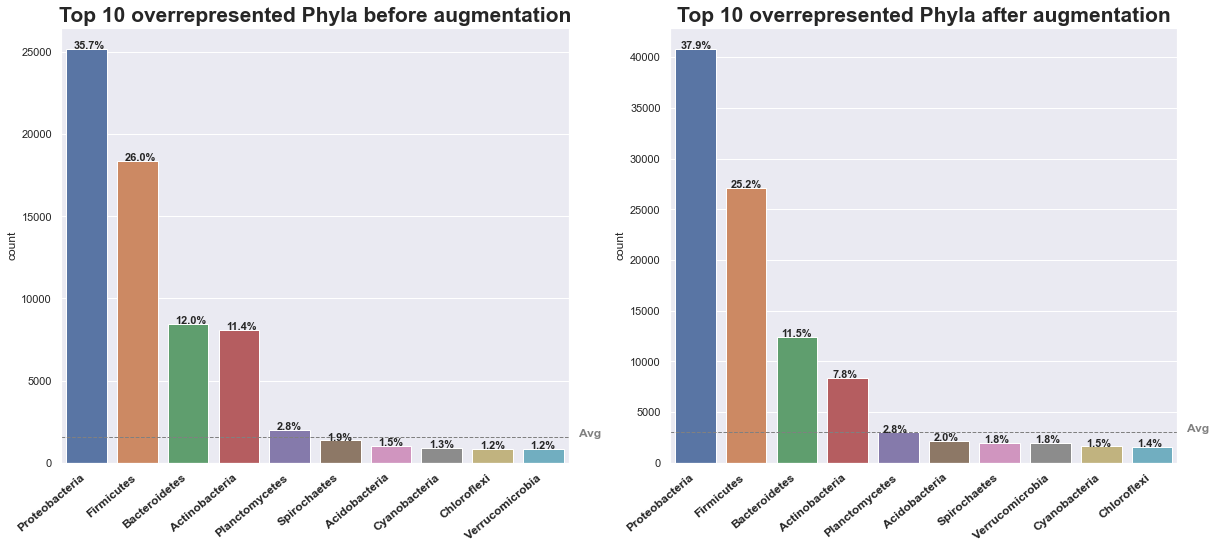

In [93]:
top_10_plot(
    taxon = 'Phylum', 
    datas = (df_full, df_full_min_max_rc),
    avgs = (phylum_avg0, phylum_avg1),
    loc = [[-0.25, 0.04], [-0.30, -0.15]])

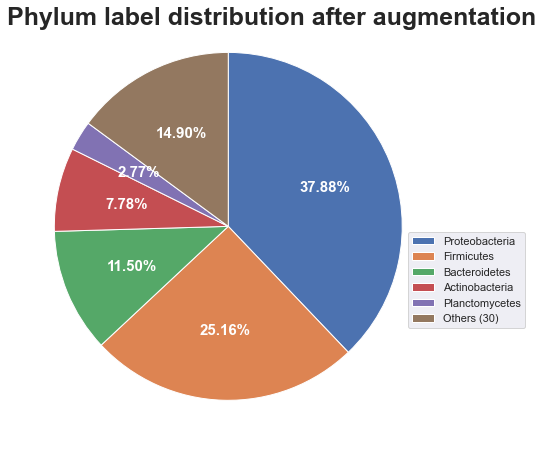

In [111]:
make_pie(
    taxon = 'Phylum', 
    taxon_df = phylum_df1, 
    taxon_head_df = phylum_head_df1, 
    taxon_others_df = phylum_others_df1,
    top = 5)

At phylum level, a majority of the dataset is labelled as Proteobacteria and Firmicutes, representing more than 60% as illustrated by a dataframe with count values, bar chart and pie chart. This demonstrates the overrepresentation of Proteobacteria and Firmicutes, as the average representation percentage of phylum labels is only 2.2%. By comparing bar charts before and after augmenting the data, an increase in the average phylum count is shown by the horizontal line in the chart.

### 2. Class

In [95]:
# table at class level before augmentation
class_avg0, class_df_with_avg0, class_df0, class_head_df0, class_others_df0 = top_table(
    taxon = 'Class', 
    data = df_full)
# table at class level after augmentation
class_avg1, class_df_with_avg1, class_df1, class_head_df1, class_others_df1 = top_table(
    taxon = 'Class', 
    data = df_full_min_max_rc)

pd.concat([class_df_with_avg0, class_df_with_avg1], keys=['Non-Augmented', 'Augmented'], axis=1).head(10)

Non-Augmented               Augmented              
                            Count Represented %     Count Represented %
Class                                                                  
AVERAGE                       699          0.99      1314          1.22
Gammaproteobacteria         11737         16.61     18967         17.59
Clostridia                   8782         12.43     13573         12.59
Bacilli                      8471         11.99     10930         10.14
Actinobacteria               6995          9.90      5878          5.45
Alphaproteobacteria          6404          9.06      8985          8.33
Bacteroidia                  3317          4.69      5707          5.29
Betaproteobacteria           2868          4.06      4459          4.14
Deltaproteobacteria          2568          3.63      5099          4.73
Flavobacteriia               2423          3.43      2741          2.54

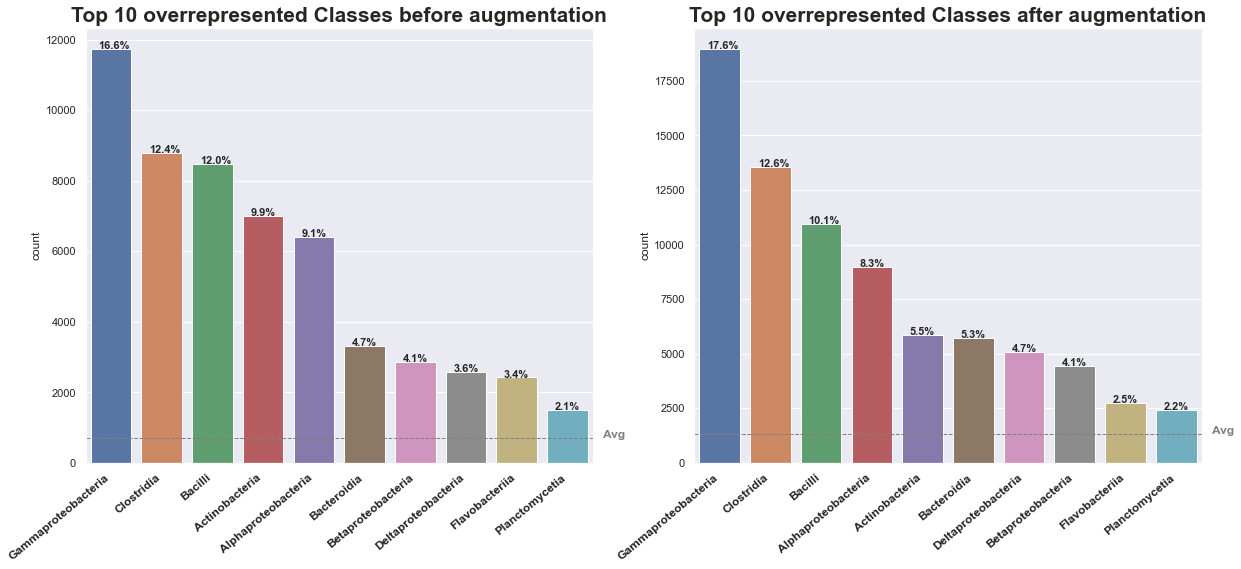

In [96]:
# top 10 Classes and their frequencies in a bar chart
top_10_plot(
    taxon = 'Class', 
    datas = (df_full, df_full_min_max_rc),
    avgs = (class_avg0, class_avg1),
    loc = [(-0.25, -0.05), (-0.25, 0.02)])

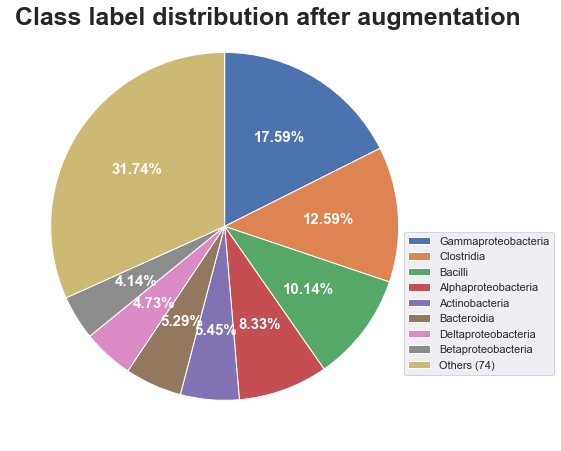

In [100]:
make_pie(
    taxon = 'Class', 
    taxon_df = class_df1, 
    taxon_head_df = class_head_df1, 
    taxon_others_df = class_others_df1)

At class level, approximately 30% of dataset has labels Gammaproteobacteria and Bacilli. The extent of over-representation of top taxa is already lower than the earlier taxonomy hierarchy. Similar to the phylum level, the average count of the entire label is increased after augmentation.

### 3. Order

In [103]:
# table at order level before augmentation
order_avg0, order_df_with_avg0, order_df0, order_head_df0, order_others_df0 = top_table(
    taxon = 'Order', 
    data = df_full)
# table at order level after augmentation
order_avg1, order_df_with_avg1, order_df1, order_head_df1, order_others_df1 = top_table(
    taxon = 'Order', 
    data = df_full_min_max_rc)

pd.concat([order_df_with_avg0, order_df_with_avg1], keys=['Non-Augmented', 'Augmented'], axis=1).head(10)

Non-Augmented               Augmented              
                         Count Represented %     Count Represented %
Order                                                               
AVERAGE                    305          0.43       623          0.58
Eubacteriales             8406         11.90     12946         12.01
Caryophanales             5502          7.79      6645          6.16
Enterobacterales          3442          4.87      5978          5.54
Bacteroidales             3301          4.67      5647          5.24
Lactobacillales           2969          4.20      4285          3.97
Flavobacteriales          2423          3.43      2741          2.54
Hyphomicrobiales          2046          2.90      3050          2.83
Burkholderiales           1815          2.57      2643          2.45
Pseudomonadales           1708          2.42      2436          2.26

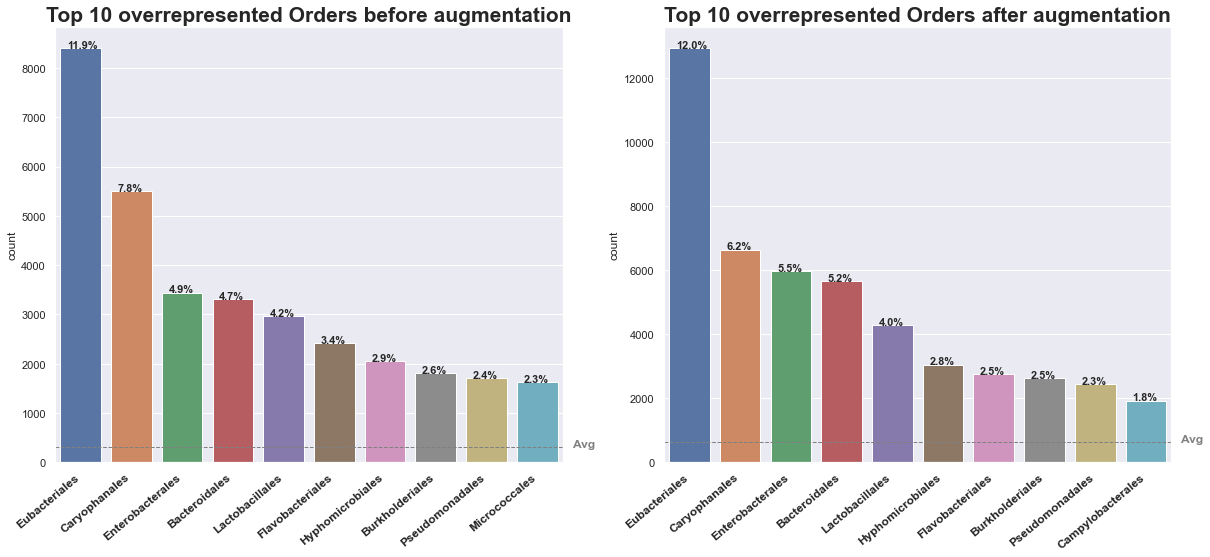

In [61]:
# top 10 Orders and their frequencies in a bar chart
top_10_plot(
    taxon = 'Order', 
    datas = (df_full, df_full_min_max_rc),
    avgs = (order_avg0, order_avg1),
    loc = [(-0.27, 0.15), (-0.27, 0.15)])

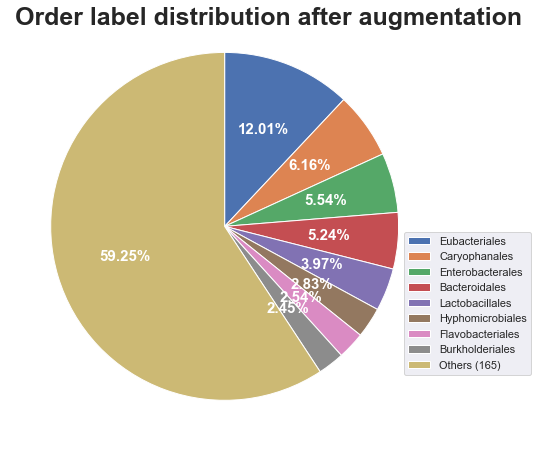

In [104]:
make_pie(
    taxon = 'Order', 
    taxon_df = order_df1, 
    taxon_head_df = order_head_df1, 
    taxon_others_df = order_others_df1)

The most over-represented order label is Eubacteriales, which represents around 12% of the dataset before, and 10% after the minimum requirement. It is clear from the order level that the extent of over-representation is much smaller as we go down through the taxon hierarchy.

### 4. Family

In [105]:
# table at family level before augmentation
family_avg0, family_df_with_avg0, family_df0, family_head_df0, family_others_df0 = top_table(
    taxon = 'Family', 
    data = df_full)
# table at family level after augmentation
family_avg1, family_df_with_avg1, family_df1, family_head_df1, family_others_df1 = top_table(
    taxon = 'Family', 
    data = df_full_min_max_rc)

pd.concat([family_df_with_avg0, family_df_with_avg1], keys=['Non-Augmented', 'Augmented'], axis=1).head(10)

Non-Augmented               Augmented              
                           Count Represented %     Count Represented %
Family                                                                
AVERAGE                      132          0.19       308          0.29
Bacillaceae                 2924          4.14      3639          3.37
Oscillospiraceae            2923          4.14      3857          3.58
Enterobacteriaceae          2137          3.02      3033          2.81
Flavobacteriaceae           2136          3.02      2028          1.88
Lachnospiraceae             2082          2.95      3267          3.03
Streptococcaceae            1248          1.77      1811          1.68
Rhodobacteraceae            1206          1.71      1227          1.14
Spirochaetaceae             1156          1.64      1447          1.34
Streptomycetaceae           1114          1.58       508          0.47

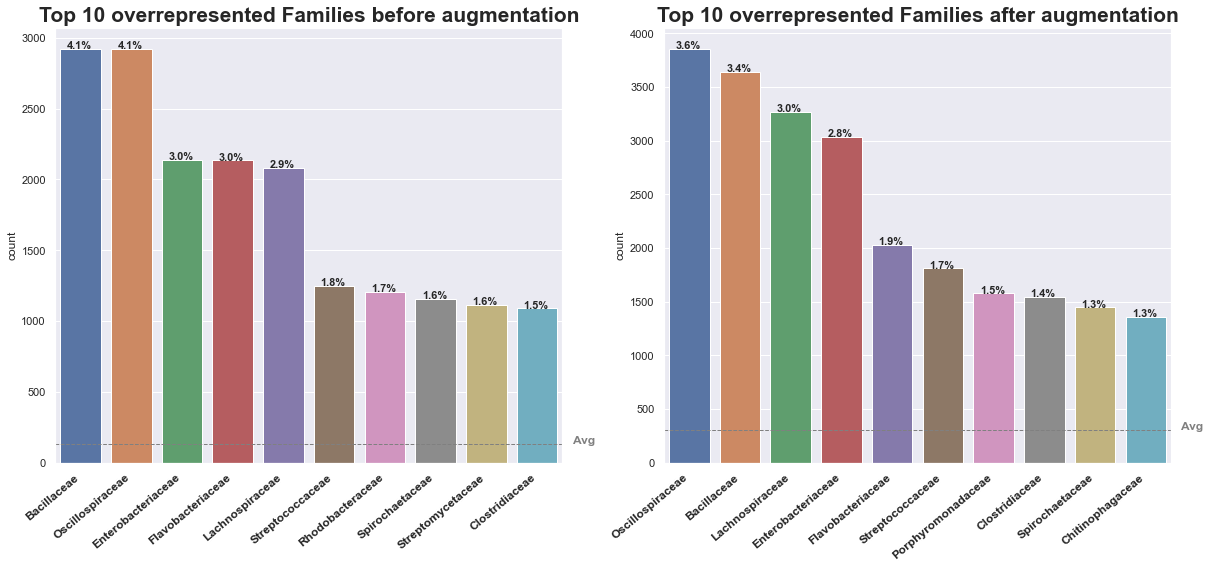

In [106]:
# top 10 Families and their frequencies in a bar chart
top_10_plot(
    taxon = 'Family', 
    datas = (df_full, df_full_min_max_rc),
    avgs = (family_avg0, family_avg1),
    loc = [(-0.27, 0.15), (-0.27, 0.15)])

At family level, which is the hierarchy level at which the classification task begins, Oscillospiraceae is the most abundant family label. The difference of the represented percentage between Oscillospiraceae and the average value is not as substantial compared to the phylum level, especially after augmentation.

### 5. Genus

In [64]:
# table at genus level before augmentation
genus_avg0, genus_df_with_avg0, genus_df0, genus_head_df0, genus_others_df0 = top_table(
    taxon = 'Genus', 
    data = df_full)
# table at genus level after augmentation
genus_avg1, genus_df_with_avg1, genus_df1, genus_head_df1, genus_others_df1 = top_table(
    taxon = 'Genus', 
    data = df_full_min_max_rc)

pd.concat([genus_df_with_avg0, genus_df_with_avg1], keys=['Non-Augmented', 'Augmented'], axis=1).head(10)

Non-Augmented               Augmented              
                           Count Represented %     Count Represented %
Genus                                                                 
AVERAGE                       21          0.03       113          0.10
Bacillus                    1271          1.80      1447          1.34
g_Oscillospiraceae          1249          1.77      1141          1.06
g_Lachnospiraceae           1205          1.71      1077          1.00
Streptococcus               1133          1.60      1540          1.43
Streptomyces                1038          1.47       468          0.43
Pseudomonas                  977          1.38      1270          1.18
Escherichia                  944          1.34       946          0.88
Lactobacillus                859          1.22      1076          1.00
Prevotella                   838          1.19       878          0.81

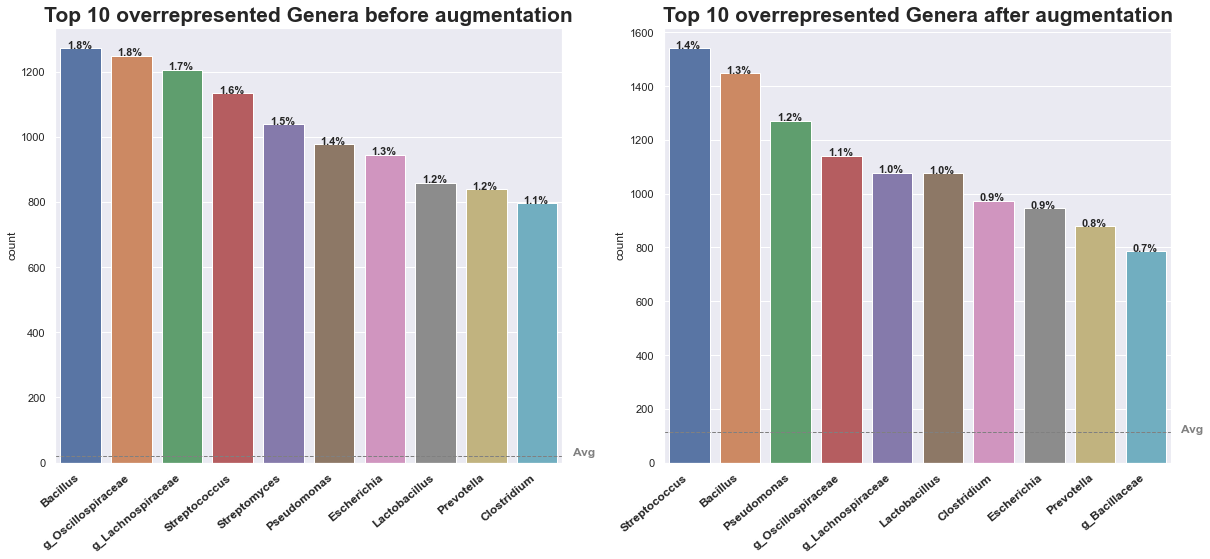

In [71]:
# top 10 Genera and their frequencies in a bar chart
top_10_plot(
    taxon = 'Genus', 
    datas = (df_full, df_full_min_max_rc),
    avgs = (genus_avg0, genus_avg1),
    loc = [(-0.27, 0.4), (-0.27, 0.4)])

At genus level, it is clear that over-representation becomes less problematic and that the augmentation steps (adding minimum and maximum requirements and reverse complement sequences) have a positive effect on normalizing the dataset.

### 6. Species

In [72]:
# table at species level before augmentation
species_avg0, species_df_with_avg0, species_df0, species_head_df0, species_others_df0 = top_table(
    taxon = 'Species', 
    data = df_full)
# table at order level after augmentation
species_avg1, species_df_with_avg1, species_df1, species_head_df1, species_others_df1 = top_table(
    taxon = 'Species', 
    data = df_full_min_max_rc)

pd.concat([species_df_with_avg0, species_df_with_avg1], keys=['Non-Augmented', 'Augmented'], axis=1).head(10)

Non-Augmented               Augmented              
                                 Count Represented %     Count Represented %
Species                                                                     
AVERAGE                              3          0.00        68          0.06
g_Oscillospiraceae sp             1238          1.75      1141          1.06
g_Lachnospiraceae sp              1165          1.65      1077          1.00
Escherichia coli                   909          1.29       896          0.83
g_Planctomycetaceae sp             704          1.00       635          0.59
g_Christensenellaceae sp           666          0.94       614          0.57
Treponema sp                       544          0.77       521          0.48
g_Rhodospirillaceae sp             506          0.72       496          0.46
Prevotella sp                      492          0.70       442          0.41
Salmonella enterica                411          0.58       410          0.38

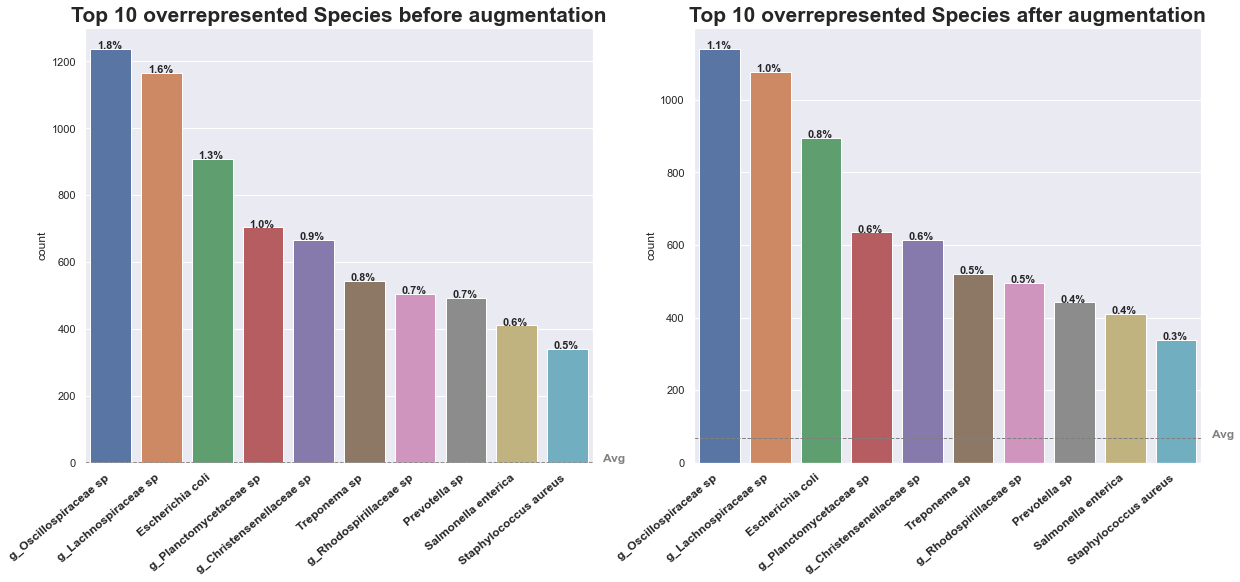

In [73]:
# top 10 Species and their frequencies in a bar chart
top_10_plot(
    taxon = 'Species', 
    datas = (df_full, df_full_min_max_rc),
    avgs = (species_avg0, species_avg1),
    loc = [(-0.27, 0.15), (-0.27, 0.15)])

For the species level, unsurprisingly, E. coli is the most over-represented (labelled) species in the dataset, which has around 1,000 counts. 

As shown in the df_full dataframe count, the most underrepresented labels only have 1 entry, causing problems in the classification task while spliting the dataset into train, validation and test for machine learning models. However, through a minimum number of entry requirement, the most under-represented label contains 5 counts, ensuring a sufficient number of entries for the data split. This validates the implementation of the minimum requirement on the final dataset, allowing to facilitate data separation.

## Data seperation

After generating the desired datasets and visualizing their properties, the data is split into a training-, validation- and test-set to be fed into the machine/deep learning models.


In order to maintain the proportions of taxons and minimize the likelihood of a taxon being absent in one of the datasets, a stratification seperation is implemented.

In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split

def df_strat_split(
    df_input, stratify_colname = 'Species', 
    frac_train = 0.6, frac_val = 0.2, frac_test = 0.2, 
    random_state = None):
    '''
    Splits a Pandas dataframe into three subsets 
    (train, val, and test) following fractional ratios provided by the user, 
    where each subset is stratified by the values in a specific column 
    (each subset has the same relative frequency of the values in the column). 
    It performs this splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. 
        Usually this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into 
        train, val, and test data. (float fractions and sum = 1.0)
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split(). 
        (simply sets a seed to the random generator)

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''
    # -----------------------------------------------------------------------------------
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            'fractions {}, {}, {} do not add up to 1.0'.format(
                frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError(
            '{} is not a column in the dataframe'.format(
                stratify_colname))
    # -----------------------------------------------------------------------------------
    X = df_input                     # dontains all columns
    y = df_input[[stratify_colname]] # dataframe of just the column on which to stratify

    # split original dataframe into train and temp dataframes
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify = y, 
        test_size = (1.0 - frac_train), 
        random_state = random_state)

    # split the temp dataframe into val and test dataframes
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp, y_temp, stratify = y_temp, 
        test_size = relative_frac_test, 
        random_state = random_state)
    # -----------------------------------------------------------------------------------
    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

### Putting it all together - For the training process

What follows is a script to generate and save the desired split datasets.

The data is split beforehand so that the different models can be trained, validated and tested with the same datasets.

In order to maintain the original data structures for the test set, seperation is performed before major data augmentations ((high minimum requirements,) maximum requirements and reverse complement sequences).

In [45]:
# ----------------------------------------------------------------------------------------------
# Loading the dataset as a pandas data frame ---------------------------------------------------
df = pd.read_csv('full_curated_dataset.csv')
print(
    'Dataset loaded, shape: {}'.format(
        df.shape))

# ----------------------------------------------------------------------------------------------
# Labeling empty cells with an informative value -----------------------------------------------
df_empty_filled = empty_fill(df)

# ----------------------------------------------------------------------------------------------
# Standardizing the species columns ------------------------------------------------------------
df_filled = standardize_sp(df_empty_filled)
print(
    'Dataset filled and standardized, shape: {}'.format(
        df_filled.shape))

# ----------------------------------------------------------------------------------------------
# Standardizing the sequence length ------------------------------------------------------------
df_full = keep_min_max_len(df_filled, min_max = (1000, 2000))
print(
    'Too short/long sequences removed, shape: {}'.format(
        df_full.shape))

# ----------------------------------------------------------------------------------------------
# Removal of highly underrepresented species ---------------------------------------------------
df_full_min = min_entries(df_full, taxon = 'Species', min = 5)
print(
    'Highly underrepresented species removed, shape: {}'.format(
        df_full_min.shape))

# ----------------------------------------------------------------------------------------------
# Add sequence ID ------------------------------------------------------------------------------
df_full_min_id = add_SeqID(df_full_min)
print(
    'Sequence ID added, shape: {}'.format(
        df_full_min_id.shape))

# ----------------------------------------------------------------------------------------------
# Splitting and saving the data ----------------------------------------------------------------
df_train_0, df_val_0, df_test_0 = df_strat_split(df_full_min_id)
df_train_0.to_csv('df_train_0.csv', index = False)
df_val_0.to_csv('df_val_0.csv', index = False)
df_test_0.to_csv('df_test_0.csv', index = False)
print(
    'Train/Val/Test split and saved\n{} - {} - {}'.format(
        df_train_0.shape, df_val_0.shape, df_test_0.shape))

# FURTHER AUGMENTATION OF TRAINING AND VALIDATION DATA
# ----------------------------------------------------------------------------------------------
# Tackle overrepresentation with nucleotide ambiguity ------------------------------------------
df_train_full_max = remove_over_repr_ambiguous(df_train_0, taxon = 'Genus')
print(
    'Train dataset un-overrepresented (at Genus level)\n{}'.format(
        df_train_full_max.shape))
        
################################################################################################
# ---------------------------------------------------------------------------------------------|
# Increase the amount of entries by adding the reverse complement sequences -------------------|
rc_df_train1 = representative_rc(df_train_full_max, taxon = 'Genus')
rc_df_val1 = representative_rc(df_val_0, taxon = 'Genus')
df_train_full_max_rc1 = pd.concat([df_train_full_max, rc_df_train1], ignore_index = True)
df_val_full_max_rc1 = pd.concat([df_val_0, rc_df_val1], ignore_index = True)
print(
    'Train/Val datasets reverse complemented at genus level\n{} - {}'.format(
        df_train_full_max_rc1.shape, df_val_full_max_rc1.shape))
# ---------------------------------------------------------------------------------------------|
rc_df_train2 = representative_rc(df_train_full_max_rc1, taxon = 'Species')
rc_df_val2 = representative_rc(df_val_full_max_rc1, taxon = 'Species')
df_train_full_max_rc = pd.concat([df_train_full_max_rc1, rc_df_train2], ignore_index = True)
df_val_full_max_rc = pd.concat([df_val_full_max_rc1, rc_df_val2], ignore_index = True)
print(
    'Train/Val datasets reverse complemented at species level\n{} - {}'.format(
        df_train_full_max_rc.shape, df_val_full_max_rc.shape))
################################################################################################

# ----------------------------------------------------------------------------------------------
# Save train/val datasets ----------------------------------------------------------------------
df_train_full_max_rc.to_csv('df_train_1.csv', index = False)
df_val_full_max_rc.to_csv('df_val_1.csv', index = False)
print(
    'Augmented Train/Val datasets saved\n{} - {}'.format(
        df_train_full_max_rc.shape, df_val_full_max_rc.shape))

Dataset loaded, shape: (70785, 8)
Dataset filled and standardized, shape: (70785, 8)
Too short/long sequences removed, shape: (70664, 8)
Highly underrepresented species removed, shape: (44663, 8)
Sequence ID added, shape: (44663, 9)
Train/Val/Test split and saved
(26797, 9) - (8933, 9) - (8933, 9)
Train dataset un-overrepresented (at Genus level)
(26414, 9)
Train/Val datasets reverse complemented at genus level
(39465, 9) - (13323, 9)
Train/Val datasets reverse complemented at species level
(64794, 9) - (21903, 9)
Augmented Train/Val datasets saved
(64794, 9) - (21903, 9)


Now the three datasets are verified to make sure they each contain the same amount of unique labels.

In [46]:
# number of unique labels at family level for the 3 datasets before augmentation
print(
    df_train_0['Family'].nunique(), 
    df_val_0['Family'].nunique(), 
    df_test_0['Family'].nunique()
    )
# number of unique labels at family level for the 3 datasets after augmentation
print(
    df_train_full_max_rc['Family'].nunique(), 
    df_val_full_max_rc['Family'].nunique(), 
    df_test_0['Family'].nunique()
    )

349 349 349


In [48]:
# number of unique labels at genus level for the 3 datasets before augmentation
print(
    df_train_0['Genus'].nunique(), 
    df_val_0['Genus'].nunique(), 
    df_test_0['Genus'].nunique()
    )
# number of unique labels at genus level for the 3 datasets after augmentation
print(
    df_train_full_max_rc['Genus'].nunique(), 
    df_val_full_max_rc['Genus'].nunique(), 
    df_test_0['Genus'].nunique()
    )

954 954 954


In [50]:
# number of unique labels at species level for the 3 datasets before augmentation
print(
    df_train_0['Species'].nunique(), 
    df_val_0['Species'].nunique(), 
    df_test_0['Species'].nunique()
    )
# number of unique labels at genus level for the 3 datasets after augmentation
print(
    df_train_full_max_rc['Species'].nunique(), 
    df_val_full_max_rc['Species'].nunique(), 
    df_test_0['Species'].nunique()
    )

1569 1569 1569


In [1]:
# Script for Python

#-------------------------------------------------------------------
# Subsetting per taxon

import pandas as pd

def subset_taxons(df, taxons = ['Genus']):
    taxons.insert(0, 'Seq_id')
    taxons.append('Sequence')
    return df[taxons]


# fe:   df = pd.read_csv('df_train_0.csv')
#       new_df = subset_taxons(df, taxons = ['Genus', 'Species'])
#       new_df.to_csv('new_name.csv', index = False)

#-------------------------------------------------------------------